In [1]:
import numpy as np
import sklearn.preprocessing, sklearn.decomposition
import pandas as pd
import torch
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import spring_helper as sh

In [2]:
expr = sh.load_mtx("original_data/normed_counts.mtx")
genes = sh.load_genes("original_data/gene_names.txt")

In [3]:
expr.shape

(130887, 25289)

In [2]:
expr = sh.load_mtx("original_data/normed_counts.mtx")
genes = sh.load_genes("original_data/gene_names.txt")
highly_variable_genes = sh.filter_genes(expr)
cell_cycle_genes = [['Ube2c',
                    'Hmgb2',
                    'Hmgn2',
                    'Tuba1b', 
                    'Ccnb1', 
                    'Tubb5', 
                    'Top2a', 
                    'Tubb4b']]
non_cell_cycle_idx = sh.remove_corr_genes(expr, gene_list=genes, exclude_corr_genes_list=cell_cycle_genes, test_gene_idx=highly_variable_genes, min_corr=0.1)
non_cell_cycle_idx = non_cell_cycle_idx[0:2447]
# perform filtering
expr = expr[:, non_cell_cycle_idx]

use_genes = [genes[i] for i in non_cell_cycle_idx]



In [13]:
meta = pd.read_csv("original_data/metadata.csv", sep = ",")
# meta = meta.drop(meta.columns[0], axis = 1)
meta.head()

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y
0,d6_2_2,GCGTGCAA-AGAAGTTA,6.0,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190
1,d6_2_2,AAGGGACC-CTCGATGC,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925
2,d6_2_2,CGTACCGA-AGCGCCTT,6.0,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300
3,d6_2_2,CTGAAGGG-AGGAGCTT,6.0,Lin-Kit+Sca1-,Neutrophil,2,1150.028,-2030.369
4,d6_2_2,CCGTAGCT-AGGCAGTT,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010


In [14]:
x = expr.todense()
y = meta['Time point'].values.astype(int)

ix_tr = meta['Time point'] != 4
ix_te = meta['Time point'] == 4

x_tr = x[ix_tr]
x_te = x[ix_te]
y_tr = y[ix_tr]
y_te = y[ix_te]

meta_tr = meta.loc[ix_tr]
meta_te = meta.loc[ix_te]


In [15]:
scaler = sklearn.preprocessing.StandardScaler()
pca = sklearn.decomposition.PCA(n_components = 50, random_state=0)
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30, random_state=42,transform_seed=42)


In [16]:
x_tr = scaler.fit_transform(x_tr)
xp_tr = pca.fit_transform(x_tr)
xu_tr = um.fit_transform(xp_tr) 

x_te = scaler.transform(x_te)
xp_te = pca.transform(x_te)
xu_te = um.transform(xp_te)

In [17]:

x_l = [x_tr[y_tr == 2,],
       x_te[y_te == 4,],
       x_tr[y_tr == 6,]]
xp_l = [xp_tr[y_tr == 2,],
        xp_te[y_te == 4,],
        xp_tr[y_tr == 6,]]
xu_l = [xu_tr[y_tr == 2,],
        xu_te[y_te == 4,],
        xu_tr[y_tr == 6,]]

x_l = [torch.from_numpy(a).float() for a in x_l]
xp_l = [torch.from_numpy(a).float() for a in xp_l]
xu_l = [torch.from_numpy(a).float() for a in xu_l]

celltype_ = [meta_tr['Cell type annotation'][(y_tr == 2)],
             meta_te['Cell type annotation'][(y_te == 4)],
             meta_tr['Cell type annotation'][(y_tr == 6)]]

genes = use_genes

In [ ]:
unique_cell_types = meta['Cell type annotation'].unique()
default_colors = sns.color_palette("husl", len(unique_cell_types))
color_palette_dict = {cell_type: color for cell_type, color in zip(unique_cell_types, default_colors)}

In [ ]:
# torch.save({
#     'x': x_l, 
#     'xp': xp_l, 
#     'xu': xu_l, 
#     'y': [2,4,6],
#     'celltype': celltype_,
#     'genes':genes,
#     'Types':unique_cell_types,
#     'colors':color_palette_dict
# }, 'leaveout1/fate_train.pt')

<AxesSubplot:>

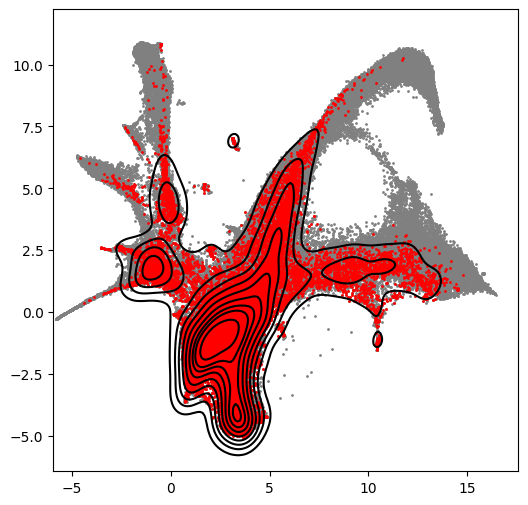

In [22]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
ax.scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')

px = y_tr == 2
ax.scatter(xu_tr[px,0], xu_tr[px, 1], color = 'red', s = 1)
sns.kdeplot(x=xu_tr[px,0], y=xu_tr[px, 1], color = 'k',ax=ax)

In [28]:
clone = sh.load_mtx("original_data/clone_matrix.mtx")
meta_ = meta.copy()
meta_['clone'] = np.asarray(np.argmax(clone, axis = 1))[:,0]
meta_.loc[np.asarray(clone.sum(axis = 1) == 0)[:,0], 'clone'] = -1

meta_.head()

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clone
0,d6_2_2,GCGTGCAA-AGAAGTTA,6.0,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190,573
1,d6_2_2,AAGGGACC-CTCGATGC,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925,1440
2,d6_2_2,CGTACCGA-AGCGCCTT,6.0,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300,394
3,d6_2_2,CTGAAGGG-AGGAGCTT,6.0,Lin-Kit+Sca1-,Neutrophil,2,1150.028,-2030.369,-1
4,d6_2_2,CCGTAGCT-AGGCAGTT,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010,1972


In [29]:
d2_meta = meta_.loc[meta_['Time point'] == 2]
d2_mask = (d2_meta['clone'] > -1).values

d4_meta = meta_.loc[meta_['Time point'] == 4]
d4_mask = (d4_meta['clone'] > -1).values

d6_meta = meta_.loc[meta_['Time point'] == 6] 
d6_mask = (d6_meta['clone'] > -1).values

In [43]:
x_l = [x_tr[y_tr == 2,][d2_mask],
       x_te[y_te == 4,][d4_mask],
       x_tr[y_tr == 6,][d6_mask]]
xp_l = [xp_tr[y_tr == 2,][d2_mask],
        xp_te[y_te == 4,][d4_mask],
        xp_tr[y_tr == 6,][d6_mask]]
xu_l = [xu_tr[y_tr == 2,][d2_mask],
        xu_te[y_te == 4,][d4_mask],
        xu_tr[y_tr == 6,][d6_mask]]

x_l = [torch.from_numpy(a).float() for a in x_l]
xp_l = [torch.from_numpy(a).float() for a in xp_l]
xu_l = [torch.from_numpy(a).float() for a in xu_l]

celltype_ = [meta_tr['Cell type annotation'][(y_tr == 2)][d2_mask],
             meta_te['Cell type annotation'][(y_te == 4)][d4_mask],
             meta_tr['Cell type annotation'][(y_tr == 6)][d6_mask]]

In [ ]:
# torch.save({
#     'x': x_l, 
#     'xp': xp_l, 
#     'xu': xu_l, 
#     'y': [2,4,6],
#     'celltype': celltype_,
#     'genes':genes,
#     'Types':unique_cell_types,
#     'colors':color_palette_dict
# }, 'leaveout1_onlyLineage/fate_train.pt')

In [11]:
# from joblib import dump
# dump(um, 'leaveout1/um_operator.joblib')
# dump(um, 'leaveout1_onlyLineage/um_operator.joblib')

['alltime/phate_operator.joblib']